In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [17]:
root_path = "/kaggle/input/flavia-dataset"

csv_path = os.path.join(root_path, "Leaves", "all.csv")
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,id,y
0,0,1300.jpg,5
1,1,3152.jpg,23
2,2,1439.jpg,9
3,3,1243.jpg,4
4,4,1186.jpg,3


In [18]:
df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={'id': 'image', 'y': 'label'})

df.head()

,image,label
0,1300.jpg,5
1,3152.jpg,23
2,1439.jpg,9
3,1243.jpg,4
4,1186.jpg,3


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907 entries, 0 to 1906
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1907 non-null   object
 1   label   1907 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.9+ KB


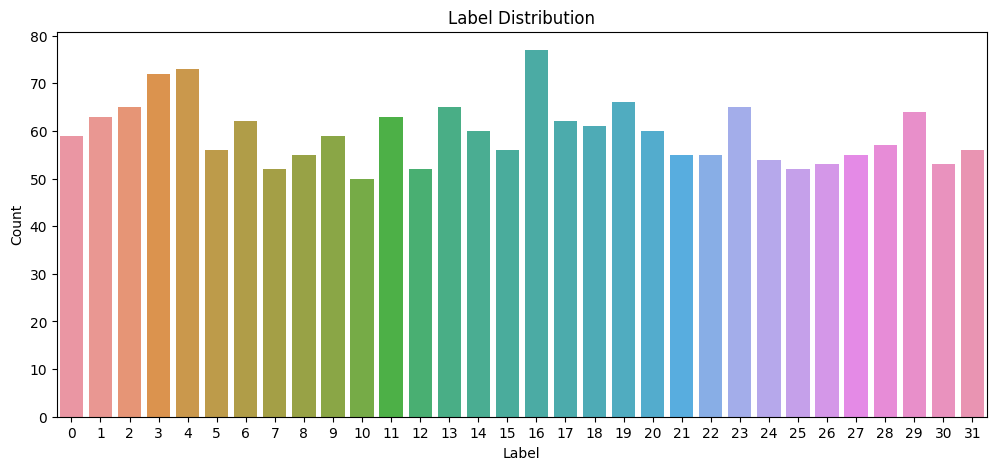

Number of classes: 32


In [20]:
plt.figure(figsize=(12,5))
sns.countplot(x=df['label'])
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("Number of classes:", df['label'].nunique())

In [21]:
y = df['label'].astype(int).values

from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

print("One-hot Y shape:", y.shape)

One-hot Y shape: (1907, 32)


In [22]:
images_path = os.path.join(root_path, "Leaves")

X = []
missing = []

for img_name in df['image']:
    img_path = os.path.join(images_path, img_name)
    img = cv2.imread(img_path)

    if img is None:
        missing.append(img_name)
        continue
        
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X.append(img)

X = np.array(X) / 255.0

print("X shape:", X.shape)
print("Missing images:", len(missing))

X shape: (1907, 224, 224, 3)
Missing images: 0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1525, 224, 224, 3), (382, 224, 224, 3), (1525, 32), (382, 32))

In [24]:
def build_vgg16_scratch(input_shape=(224, 224, 3), num_classes=32):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))

    # Block 2
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))

    # Block 3
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))

    # Block 4
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))

    # Block 5
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))

    # Classifier
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [25]:
num_classes = y.shape[1]

model = build_vgg16_scratch(num_classes=num_classes)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │        16,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,576,672 (105.20 MB)

 Trainable params: 27,576,672 (105.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=35,
    batch_size=32
)

Epoch 1/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 328ms/step - accuracy: 0.0278 - loss: 3.4665 - val_accuracy: 0.0497 - val_loss: 3.4651
Epoch 2/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.0511 - loss: 3.4126 - val_accuracy: 0.3560 - val_loss: 2.5095
Epoch 3/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.3018 - loss: 2.4270 - val_accuracy: 0.5445 - val_loss: 1.5128
Epoch 4/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.4829 - loss: 1.6988 - val_accuracy: 0.6623 - val_loss: 1.1664
Epoch 5/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.5591 - loss: 1.4270 - val_accuracy: 0.7016 - val_loss: 0.9828
Epoch 6/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.6740 - loss: 1.1270 - val_accuracy: 0.7696 - val_loss: 0.7008
Epoch 7/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.7002 - loss: 0.9417 - val_accuracy: 0.8089 - val_loss: 0.6486
Epoch 8/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.7827 - loss: 0.6978 - val_accu

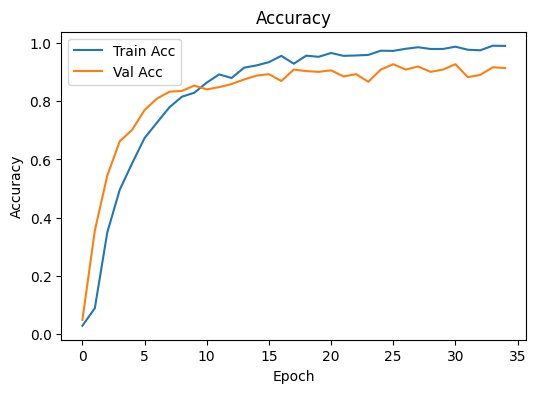

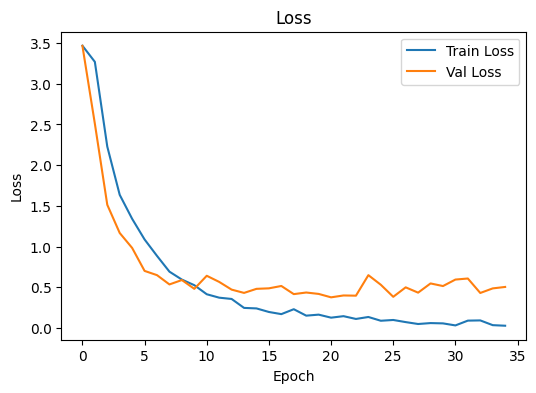

In [27]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


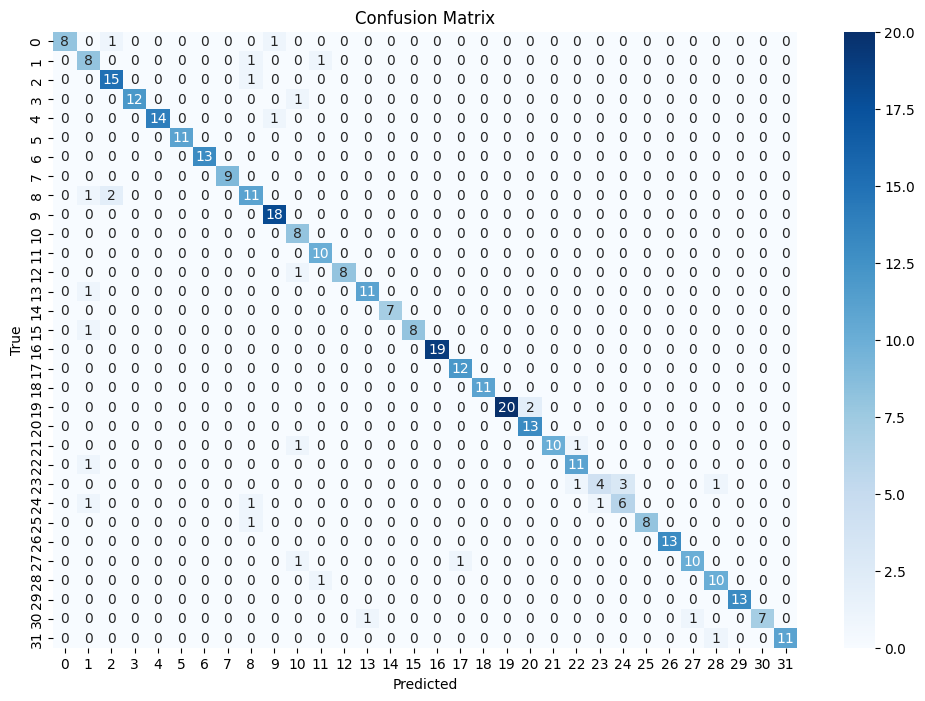

In [28]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

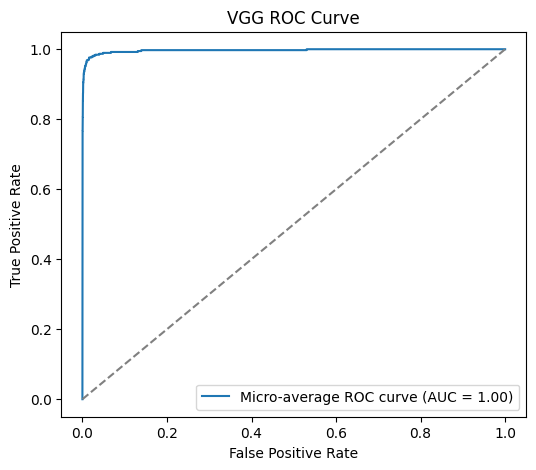

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# y_test and y_pred are one-hot encoded
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(6,5))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("VGG ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [30]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.62      0.80      0.70        10
           2       0.83      0.94      0.88        16
           3       1.00      0.92      0.96        13
           4       1.00      0.93      0.97        15
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00         9
           8       0.73      0.79      0.76        14
           9       0.90      1.00      0.95        18
          10       0.67      1.00      0.80         8
          11       0.83      1.00      0.91        10
          12       1.00      0.89      0.94         9
          13       0.92      0.92      0.92        12
          14       1.00      1.00      1.00         7
          15       1.00      0.89      0.94         9
          16       1.00      1.00      1.00        19
          17       0.92    